In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
    
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import *

In [2]:
model_name = 'resnet'

cifar100_model_train = np.load(f'./data/CIFAR100_{model_name}_train_feat.npy')
cifar100_model_test = np.load(f'./data/CIFAR100_{model_name}_test_feat.npy')
print(cifar100_model_train.shape, cifar100_model_test.shape)

cifar100_vanilla_train = np.load(f'./data/CIFAR100_vae_vanilla_{model_name}_encoding_train.npy')
cifar100_vanilla_test = np.load(f'./data/CIFAR100_vae_vanilla_{model_name}_encoding_test.npy')
print(cifar100_vanilla_train.shape, cifar100_vanilla_test.shape)

cifar100_injected_train = np.load(f'./data/CIFAR100_vae_injected_{model_name}_encoding_train.npy')
cifar100_injected_test = np.load(f'./data/CIFAR100_vae_injected_{model_name}_encoding_test.npy')
print(cifar100_injected_train.shape, cifar100_injected_test.shape)

cifar100_adapted_train = np.load(f'./data/CIFAR100_vae_adapted_{model_name}_encoding_train.npy')
cifar100_adapted_test = np.load(f'./data/CIFAR100_vae_adapted_{model_name}_encoding_test.npy')
print(cifar100_adapted_train.shape, cifar100_adapted_test.shape)

(train_images, train_labels), (test_images, test_labels) = datasets.cifar100.load_data()

(50000, 2048) (10000, 2048)
(50000, 2048) (10000, 2048)
(50000, 2048) (10000, 2048)
(50000, 2048) (10000, 2048)


In [3]:
input_shape = (cifar100_model_train.shape[1],)
batch_size = 128
epochs = 100
val_split=0.2
lr = 1e-4
callbacks = [
    #ReduceLROnPlateau(patience=5, factor=0.1),
    #EarlyStopping(monitor='loss', patience=5)
]


In [4]:
%%time

model = Sequential( [
    Input(shape=input_shape),
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(100, activation='softmax')
], name=model_name)

model.compile(
    optimizer=Adam(lr=lr),  
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#model.summary()

model_hist = model.fit(
    x=cifar100_model_train, 
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_split=val_split,
    callbacks=callbacks
)

model_eval = model.evaluate(
    x=cifar100_model_test,
    y=test_labels,
    batch_size=batch_size
)

print(f'{model.name} test - loss: {model_eval[0]}, accuracy: {model_eval[1]}')

Epoch 1/100
313/313 [==============================] - 8s 7ms/step - loss: 4.5146 - accuracy: 0.0633 - val_loss: 3.5339 - val_accuracy: 0.1993
Epoch 2/100
313/313 [==============================] - 2s 5ms/step - loss: 3.3503 - accuracy: 0.2374 - val_loss: 3.1066 - val_accuracy: 0.2675
Epoch 3/100
313/313 [==============================] - 2s 5ms/step - loss: 2.9543 - accuracy: 0.3081 - val_loss: 2.8852 - val_accuracy: 0.3063
Epoch 4/100
313/313 [==============================] - 1s 5ms/step - loss: 2.6822 - accuracy: 0.3538 - val_loss: 2.7387 - val_accuracy: 0.3297
Epoch 5/100
313/313 [==============================] - 2s 5ms/step - loss: 2.4977 - accuracy: 0.3874 - val_loss: 2.6445 - val_accuracy: 0.3435
Epoch 6/100
313/313 [==============================] - 1s 5ms/step - loss: 2.3627 - accuracy: 0.4078 - val_loss: 2.5698 - val_accuracy: 0.3565
Epoch 7/100
313/313 [==============================] - 1s 5ms/step - loss: 2.2404 - accuracy: 0.4375 - val_loss: 2.5237 - val_accuracy: 0.3679

Epoch 58/100
313/313 [==============================] - 1s 5ms/step - loss: 0.1269 - accuracy: 0.9857 - val_loss: 4.1967 - val_accuracy: 0.3433
Epoch 59/100
313/313 [==============================] - 1s 5ms/step - loss: 0.1165 - accuracy: 0.9880 - val_loss: 4.2686 - val_accuracy: 0.3408
Epoch 60/100
313/313 [==============================] - 1s 5ms/step - loss: 0.1068 - accuracy: 0.9898 - val_loss: 4.3213 - val_accuracy: 0.3399
Epoch 61/100
313/313 [==============================] - 1s 5ms/step - loss: 0.1034 - accuracy: 0.9903 - val_loss: 4.3690 - val_accuracy: 0.3420
Epoch 62/100
313/313 [==============================] - 1s 5ms/step - loss: 0.0951 - accuracy: 0.9908 - val_loss: 4.4143 - val_accuracy: 0.3412
Epoch 63/100
313/313 [==============================] - 1s 5ms/step - loss: 0.0897 - accuracy: 0.9921 - val_loss: 4.4786 - val_accuracy: 0.3406
Epoch 64/100
313/313 [==============================] - 1s 5ms/step - loss: 0.0845 - accuracy: 0.9930 - val_loss: 4.5270 - val_accuracy:

In [5]:
%%time

vanilla_model = Sequential([
    Input(shape=input_shape),
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(100, activation='softmax')
], name='vanilla')

vanilla_model.compile(
    optimizer=Adam(lr=lr),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#vanilla_model.summary()

vanilla_hist = vanilla_model.fit(
    x=cifar100_vanilla_train, 
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_split=val_split,
    callbacks=callbacks
)

vanilla_model_eval = vanilla_model.evaluate(
    x=cifar100_vanilla_test, 
    y=test_labels,
    batch_size=batch_size
)

print(f'{vanilla_model.name} test - loss: {vanilla_model_eval[0]}, accuracy: {vanilla_model_eval[1]}')

Epoch 1/100
313/313 [==============================] - 2s 5ms/step - loss: 5.1282 - accuracy: 0.0090 - val_loss: 4.9976 - val_accuracy: 0.0126
Epoch 2/100
313/313 [==============================] - 1s 5ms/step - loss: 4.7945 - accuracy: 0.0189 - val_loss: 4.9372 - val_accuracy: 0.0132
Epoch 3/100
313/313 [==============================] - 1s 5ms/step - loss: 4.5562 - accuracy: 0.0315 - val_loss: 4.8775 - val_accuracy: 0.0149
Epoch 4/100
313/313 [==============================] - 1s 5ms/step - loss: 4.3663 - accuracy: 0.0499 - val_loss: 4.8321 - val_accuracy: 0.0158
Epoch 5/100
313/313 [==============================] - 1s 5ms/step - loss: 4.2059 - accuracy: 0.0709 - val_loss: 4.8006 - val_accuracy: 0.0188
Epoch 6/100
313/313 [==============================] - 1s 5ms/step - loss: 4.0614 - accuracy: 0.0904 - val_loss: 4.7829 - val_accuracy: 0.0202
Epoch 7/100
313/313 [==============================] - 1s 5ms/step - loss: 3.9243 - accuracy: 0.1207 - val_loss: 4.7766 - val_accuracy: 0.0213

Epoch 58/100
313/313 [==============================] - 1s 5ms/step - loss: 0.2325 - accuracy: 0.9860 - val_loss: 10.0974 - val_accuracy: 0.0215
Epoch 59/100
313/313 [==============================] - 2s 5ms/step - loss: 0.2187 - accuracy: 0.9875 - val_loss: 10.2299 - val_accuracy: 0.0224
Epoch 60/100
313/313 [==============================] - 2s 5ms/step - loss: 0.2051 - accuracy: 0.9882 - val_loss: 10.3634 - val_accuracy: 0.0224
Epoch 61/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1925 - accuracy: 0.9897 - val_loss: 10.4933 - val_accuracy: 0.0214
Epoch 62/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1789 - accuracy: 0.9911 - val_loss: 10.6454 - val_accuracy: 0.0208
Epoch 63/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1693 - accuracy: 0.9924 - val_loss: 10.7569 - val_accuracy: 0.0205
Epoch 64/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1632 - accuracy: 0.9920 - val_loss: 10.8961 - val_ac

In [6]:
%%time

injected_model = tf.keras.Sequential([
    Input(shape=input_shape),
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(100, activation='softmax')
], name='injected')

injected_model.compile(
    optimizer=Adam(lr=lr),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#injected_model.summary()

injected_hist = injected_model.fit(
    x=cifar100_injected_train, 
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_split=val_split,
    callbacks=callbacks
)

injected_model_eval = injected_model.evaluate(
    x=cifar100_injected_test, 
    y=test_labels,
    batch_size=batch_size
)

print(f'{injected_model.name} test - loss: {injected_model_eval[0]}, accuracy: {injected_model_eval[1]}')

Epoch 1/100
313/313 [==============================] - 2s 5ms/step - loss: 4.6153 - accuracy: 0.0105 - val_loss: 4.6053 - val_accuracy: 0.0085
Epoch 2/100
313/313 [==============================] - 2s 5ms/step - loss: 4.6052 - accuracy: 0.0094 - val_loss: 4.6055 - val_accuracy: 0.0086
Epoch 3/100
313/313 [==============================] - 2s 5ms/step - loss: 4.6051 - accuracy: 0.0099 - val_loss: 4.6057 - val_accuracy: 0.0086
Epoch 4/100
313/313 [==============================] - 2s 5ms/step - loss: 4.6051 - accuracy: 0.0111 - val_loss: 4.6058 - val_accuracy: 0.0077
Epoch 5/100
313/313 [==============================] - 2s 5ms/step - loss: 4.6050 - accuracy: 0.0105 - val_loss: 4.6060 - val_accuracy: 0.0086
Epoch 6/100
313/313 [==============================] - 1s 5ms/step - loss: 4.6051 - accuracy: 0.0099 - val_loss: 4.6061 - val_accuracy: 0.0077
Epoch 7/100
313/313 [==============================] - 1s 5ms/step - loss: 4.6051 - accuracy: 0.0092 - val_loss: 4.6062 - val_accuracy: 0.0077

Epoch 58/100
313/313 [==============================] - 1s 5ms/step - loss: 4.6046 - accuracy: 0.0112 - val_loss: 4.6077 - val_accuracy: 0.0077
Epoch 59/100
313/313 [==============================] - 1s 5ms/step - loss: 4.6049 - accuracy: 0.0102 - val_loss: 4.6078 - val_accuracy: 0.0077
Epoch 60/100
313/313 [==============================] - 1s 5ms/step - loss: 4.6051 - accuracy: 0.0111 - val_loss: 4.6078 - val_accuracy: 0.0077
Epoch 61/100
313/313 [==============================] - 1s 5ms/step - loss: 4.6049 - accuracy: 0.0108 - val_loss: 4.6078 - val_accuracy: 0.0077
Epoch 62/100
313/313 [==============================] - 1s 5ms/step - loss: 4.6049 - accuracy: 0.0105 - val_loss: 4.6078 - val_accuracy: 0.0077
Epoch 63/100
313/313 [==============================] - 1s 5ms/step - loss: 4.6049 - accuracy: 0.0101 - val_loss: 4.6078 - val_accuracy: 0.0077
Epoch 64/100
313/313 [==============================] - 1s 5ms/step - loss: 4.6049 - accuracy: 0.0104 - val_loss: 4.6078 - val_accuracy:

In [7]:
%%time

adapted_model = Sequential([
    Input(shape=input_shape),
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(100, activation='softmax')
],name='adapted' )

adapted_model.compile(
    optimizer=Adam(lr=lr),             
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#adapted_model.summary()

adapted_hist = adapted_model.fit(
    x=cifar100_adapted_train, 
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_split=val_split,
    callbacks=callbacks
)

adapted_model_eval = adapted_model.evaluate(
    x=cifar100_adapted_test, 
    y=test_labels,
    batch_size=batch_size
)

print(f'{adapted_model.name} test - loss: {adapted_model_eval[0]}, accuracy: {adapted_model_eval[1]}')

Epoch 1/100
313/313 [==============================] - 2s 5ms/step - loss: 4.9657 - accuracy: 0.0145 - val_loss: 4.6599 - val_accuracy: 0.0126
Epoch 2/100
313/313 [==============================] - 1s 5ms/step - loss: 4.6054 - accuracy: 0.0399 - val_loss: 4.6460 - val_accuracy: 0.0158
Epoch 3/100
313/313 [==============================] - 1s 5ms/step - loss: 4.3246 - accuracy: 0.0725 - val_loss: 4.6040 - val_accuracy: 0.0180
Epoch 4/100
313/313 [==============================] - 1s 5ms/step - loss: 4.0540 - accuracy: 0.1084 - val_loss: 4.5882 - val_accuracy: 0.0194
Epoch 5/100
313/313 [==============================] - 2s 5ms/step - loss: 3.8057 - accuracy: 0.1389 - val_loss: 4.5443 - val_accuracy: 0.0198
Epoch 6/100
313/313 [==============================] - 2s 5ms/step - loss: 3.5874 - accuracy: 0.1728 - val_loss: 4.5240 - val_accuracy: 0.0209
Epoch 7/100
313/313 [==============================] - 1s 5ms/step - loss: 3.4279 - accuracy: 0.1950 - val_loss: 4.4465 - val_accuracy: 0.0237

Epoch 58/100
313/313 [==============================] - 2s 5ms/step - loss: 0.8156 - accuracy: 0.7888 - val_loss: 4.4423 - val_accuracy: 0.0979
Epoch 59/100
313/313 [==============================] - 2s 5ms/step - loss: 0.8007 - accuracy: 0.7935 - val_loss: 4.3433 - val_accuracy: 0.1156
Epoch 60/100
313/313 [==============================] - 2s 5ms/step - loss: 0.7601 - accuracy: 0.8013 - val_loss: 4.4015 - val_accuracy: 0.1090
Epoch 61/100
313/313 [==============================] - 2s 5ms/step - loss: 0.7556 - accuracy: 0.8054 - val_loss: 4.5069 - val_accuracy: 0.1012
Epoch 62/100
313/313 [==============================] - 2s 5ms/step - loss: 0.7167 - accuracy: 0.8185 - val_loss: 4.3526 - val_accuracy: 0.1178
Epoch 63/100
313/313 [==============================] - 2s 5ms/step - loss: 0.7013 - accuracy: 0.8204 - val_loss: 4.6167 - val_accuracy: 0.0987
Epoch 64/100
313/313 [==============================] - 1s 5ms/step - loss: 0.6842 - accuracy: 0.8259 - val_loss: 4.4216 - val_accuracy:

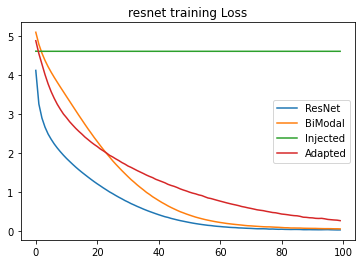

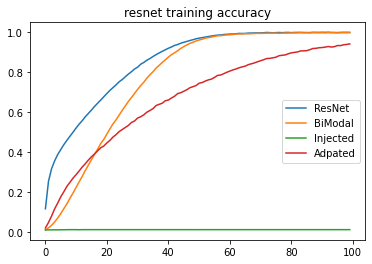

In [8]:
metric = 'accuracy'
plt.plot(model_hist.history['loss'], label=f'ResNet')
plt.plot(vanilla_hist.history['loss'], label='BiModal')
plt.plot(injected_hist.history['loss'], label='Injected')
plt.plot(adapted_hist.history['loss'], label='Adapted')
plt.legend()
plt.title(f'{model_name } training Loss')
plt.savefig(f'./plots/{model_name}/loss.png')
plt.show()

plt.plot(model_hist.history[f'{metric}'], label=f'ResNet')
plt.plot(vanilla_hist.history[f'{metric}'], label='BiModal')
plt.plot(injected_hist.history[f'{metric}'], label='Injected')
plt.plot(adapted_hist.history[f'{metric}'], label='Adpated')
plt.legend()
plt.title(f'{model_name} training accuracy')
plt.savefig(f'./plots/{model_name}/accuracy.png')
plt.show()

In [9]:
test_data = {
    'model': [f'{model_name}', f'{model_name}_vanilla', f'{model_name}_injected', f'{model_name}_adapted'],
    f'loss': [model_eval[0], vanilla_model_eval[0], injected_model_eval[0], adapted_model_eval[0]],
    f'acc': [model_eval[1], vanilla_model_eval[1], injected_model_eval[1], adapted_model_eval[1]]
}

test_df = pd.DataFrame(data=test_data)
              
test_df.to_csv(f'results/{model_name}_test_df.csv') 

test_df.head()

,model,loss,acc
0,resnet,6.029137,0.3321
1,resnet_vanilla,14.635689,0.0197
2,resnet_injected,4.605448,0.0100
3,resnet_adapted,5.540107,0.1271
